<a href="https://colab.research.google.com/github/mbenitah/IFT6135_HW1/blob/master/IFT6135_HW1_Q1_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [0]:
# Loading
import torch
from torchvision import datasets, transforms, utils

# ---- Visualizing
import matplotlib.pyplot as plt
import numpy as np

# Loading Data

In [0]:
BATCH_SIZE = 16
N_EPOCHS = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
    ])

transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
    ])

trainset = datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)   

## Visualizing some samples

Labels:  tensor([5, 2, 7, 3, 6, 1, 9, 0, 3, 7, 3, 5, 2, 2, 4, 2])
Batch shape:  torch.Size([16, 1, 28, 28])


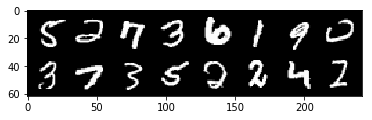

Process Process-531:
Process Process-532:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(ti

In [0]:
# functions to show an image

def show_batch(batch):
    im = utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)    
    


# Creating a MLP

In [0]:
def relu(x):
    return (x > 0) * x


def softmax(x, axis=1):
    '''Returns a matrix of size n_sample * n_features.'''
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def onehot(y, n_classes):
    '''Returns a matrix of size n_samples * n_classes with the one-hot
    representation of the category of sample i in line i-th of the matrix,
    that is a line full of zeros except for the j-th column that is equal to
    1, where j is the class of sample i.
    y is a vector of integers between 0 and n_classes - 1.
    y may have one or more lines. Each line is the label of each sample.'''
    
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

In [0]:
class MLP(object):
    
#    def __init__(self, d0, d1, d2, d3, mode='train', type='Zeros'
#                 datapath=None, model_path=None):
    def __init__(self, d0, d1, d2, d3, init_type='Zeros'):

        super(MLP, self).__init__()
        #self.mode = mode
        self.d0 = d0
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.init_type = init_type
        
        self.W1 = self.initialize_weights(d0, d1, type=self.init_type)
        self.W2 = self.initialize_weights(d1, d2, type=self.init_type)
        self.W3 = self.initialize_weights(d2, d3, type=self.init_type)
        
        self.b1 = np.zeros(d1)
        self.b2 = np.zeros(d2)
        self.b3 = np.zeros(d3)
        
        self.parameters = [self.b1, self.W1, self.b2, self.W2, self.b3, self.W3]


    def initialize_weights(self, in_dim, out_dim, type='Zeros'):
        if type == 'Normal':           
            return np.random.normal(1, 1, size=(out_dim, in_dim))
            
        elif type == 'Glorot':
            dl = np.sqrt(6 / (in_dim + out_dim))
            return np.random.uniform(-dl, dl, size=(out_dim, in_dim))

        else:
            # Zeros
            return np.zeros(shape=(out_dim, in_dim))
            #return np.ones(shape=(out_dim, in_dim)) * 1e-3


   
    def forward(self, x):
        h1 = np.dot(x, self.W1.T) + self.b1
        a1 = self.activation(h1)
        h2 = np.dot(a1, self.W2.T) + self.b2
        a2 = self.activation(h2)
        o = np.dot(a2, self.W3.T) + self.b3
        os = softmax(o, axis=1)
        return h1, a1, h2, a2, o, os

    
    def activation(self, input):
        return relu(input)

    
    def loss(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)

    
    def backward(self, y, x, h1, a1, h2, a2, o, os, weight_decay=0):
        
        n_samples = x.shape[0]
        
        dl_do = os - y
        
        dl_da2 = np.dot(dl_do, self.W3)
        dl_dh2 = (h2 > 0) * dl_da2
        dl_da1 = np.dot(dl_dh2, self.W2)
        dl_dh1 = (h1 > 0) * dl_da1
 
        dl_dW3 = np.dot(dl_do.T, a2) / n_samples + weight_decay * self.W3
        dl_db3 = dl_do.mean(axis=0)
        dl_dW2 = np.dot(dl_dh2.T, a1) / n_samples + weight_decay * self.W2
        dl_db2 = dl_dh2.mean(axis=0)
        dl_dW1 = np.dot(dl_dh1.T, x) / n_samples + weight_decay * self.W1
        dl_db1 = dl_dh1.mean(axis=0)
        
        return dl_db1, dl_dW1, dl_db2, dl_dW2, dl_db3, dl_dW3   

    
#    def update(self,grads,..):

        

    def train(self, trainloader, n_epochs=10, eta=1e-1, weight_decay=0.):
        '''data contains one batch with inputs x and targets y'''
        avg_loss = np.zeros(n_epochs)
        for epoch in range(n_epochs):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                
                # get the inputs and labels
                x, y = data
                
                # flatten data
                x = x.view(BATCH_SIZE, -1)
                
                y = onehot(y, 10)
                
                h1, a1, h2, a2, o, os = self.forward(x)
                avg_grads = self.backward(y, x, h1, a1, h2, a2, o, os, weight_decay)
                #avg_loss[epoch] = self.loss(os, y)
                
                # update grads for each parameter
                for p, grad in zip(self.parameters, avg_grads):
                    p -= eta * grad
                
                #if i % 2000 == 1999:    # print every 2000 mini-batches
                #    print('[%d, %5d] loss: %.3f' %
                #      (epoch + 1, i + 1, avg_loss[epoch]))
                #    #avg_loss = 0.0
            
            avg_loss[epoch] = self.loss(os, y)
            print('Epoch %2d loss: %.3f' %
                      (epoch + 1, avg_loss[epoch]))    
        return avg_loss
    
    
    def predict(self, x):
        _, _, _, _, _, os = self.forward(x)
        return os.argmax(axis=1)

    
    def test(self, x, y):
        _, _, _, _, _, os = self.forward(x)       
    

In [0]:
d0 = 28 * 28
d1 = 512
d2 = 512
d3 = 10

n_parameters = d0 * d1 + d1 + d1 * d2 + d2 + d2 * d3 + d3
print('Total number of parameters: %d' % n_parameters)

Total number of parameters: 669706


Epoch  1 loss: 0.242
Epoch  2 loss: 0.005
Epoch  3 loss: 0.002
Epoch  4 loss: 0.007
Epoch  5 loss: 0.062
Epoch  6 loss: 0.012
Epoch  7 loss: 0.004
Epoch  8 loss: 0.019
Epoch  9 loss: 0.000
Epoch 10 loss: 0.000
Glorot executed in 2.2 minutes

Model with Glorot initialization
Accuracy of 0: 99.4%
Accuracy of 1: 99.4%
Accuracy of 2: 97.9%
Accuracy of 3: 98.7%
Accuracy of 4: 97.5%
Accuracy of 5: 97.9%
Accuracy of 6: 98.4%
Accuracy of 7: 98.4%
Accuracy of 8: 98.4%
Accuracy of 9: 97.7%

Overall accuracy: 98.4%




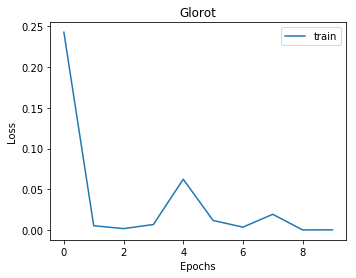

In [0]:
import time

plt.figure(figsize=(18, 4))
#for i, init_type in enumerate(['Glorot', 'Normal', 'Zeros']):
for i, init_type in enumerate(['Glorot']):

    start_time = time.time()
    model = MLP(d0, d1, d2, d3, init_type)
    loss = model.train(trainloader, n_epochs=N_EPOCHS, eta=1e-1, weight_decay=0.)
    total_time = time.time() - start_time
    print('%s executed in %.1f minutes\n' % (init_type, total_time / 60.0))
    axis = plt.subplot(1, 3, i + 1)
    axis.plot(range(N_EPOCHS), loss, label='train')
    axis.set_title(init_type)
    axis.legend()
    axis.set_ylabel('Loss')
    axis.set_xlabel('Epochs')
    get_accuracy(model)

In [0]:
def get_accuracy(model):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for data in testloader:
        images, labels = data
        x = images.view(BATCH_SIZE, -1)
        pred = model.predict(x)
        c = (pred == labels).squeeze()
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

    print('Model with %s initialization' % (model.init_type))
    for i in range(10):
        print('Accuracy of %1s: %.1f%%' % (
            i, 100 * class_correct[i] / class_total[i]))

    print()
    print('Overall accuracy: %.1f%%\n\n' %
          (100 * sum(class_correct) / sum(class_total)))


Text(0.5, 0, 'Epochs')

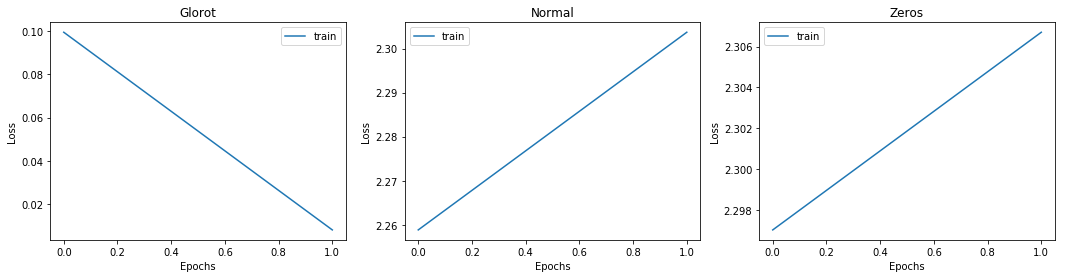

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
axis = plt.subplot(1, 3, 1)
axis.plot(range(N_EPOCHS), loss_glorot, label='train')
axis.set_title('Glorot')
axis.legend()
axis.set_ylabel('Loss')
axis.set_xlabel('Epochs')

axis = plt.subplot(1, 3, 2)
axis.plot(range(N_EPOCHS), loss_normal, label='train')
axis.set_title('Normal')
axis.legend()
axis.set_ylabel('Loss')
axis.set_xlabel('Epochs')

axis = plt.subplot(1, 3, 3)
axis.plot(range(N_EPOCHS), loss_zeros, label='train')
axis.set_title('Zeros')
axis.legend()
axis.set_ylabel('Loss')
axis.set_xlabel('Epochs')
#axis.imsave(model.init_type + N_EPOCHS)




Prediction:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


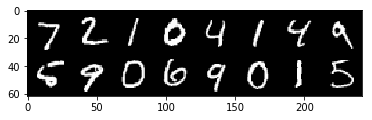

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
x = images.view(BATCH_SIZE, -1)
show_batch(images)
print('Prediction: ', model.predict(x))

In [0]:
correct = 0
#n_samples = 0
#misclassified = []
#correct_labels = []
x = []
for data in testloader:
    inputs, labels = data
    x.append(inputs)
x_ = x.view(BATCH_SIZE, -1)
    
    
pred = model.predict(x)
correct = (pred == labels).sum()
print('Accuracy: %.2f' % (correct / x.shape[0] * 100))


    
    
    
#    n_samples += x.shape[0]
#    misclassified.append(x[pred != labels])
#    correct_labels.append(labels[pred != labels])
#    correct += (pred == labels).sum()
#if misclassified != []:
#    show_batch(misclassified)
#    print(correct_labels)
#print('Accuracy: %.2f' % (correct / n_samples * 100))
    #if idx % 2000 == 0:
    #    show_batch(images)
    #    print('Prediction: ', pred)
    #correct += (pred == labels).sum()



AttributeError: 'list' object has no attribute 'view'

In [0]:
x


[tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0

In [0]:
def test(model, testloader, n):
    correct = 0
    for data in testloader:
        inputs, labels = data
        pred = predict(model, inputs)
        correct += (pred == labels).sum()
    return 100 * correct / n

print('Accuracy: ', test(model, testloader, len(testset)))

In [0]:
def predict(model, images):
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)  # TODO: explain why 1
    return predicted

In [0]:
import torch
import numpy as np
y = np.zeros((4,3,3))
y = torch.from_numpy(y)
y[1,:,:]=1
y[2,:,:]=2
y[3,:,:]=3
y
x = y.view(4,-1)   #this is torch view
x

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3.]], dtype=torch.float64)